### Data fields
- Age (years)
- Height (in)
- Weight (lbs)
- Sex
- Race (4)
- Resting HR (bpm)
- Systolic BP
- Diastolic BP
- Blood sugar (mg/dL)

In [14]:
# Import PyTorch dependencies

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as tud
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

import math

### Global variables

In [15]:
BATCH_SIZE = 64
NUM_PARAMETERS = 12

DISCRIMINATOR_LAYERS = [
    NUM_PARAMETERS, 30, 30, 20, 10, 5, 2
]

GENERATOR_DIM = 40

GENERATOR_LAYERS = [
    GENERATOR_DIM, 20, 30, 20, NUM_PARAMETERS
]

DISCRIMINATOR_LEARNING_RATE = 0.002
GENERATOR_LEARNING_RATE     = 0.002

### Helper functions and variables

In [16]:
#declare some variables
#min and max range of ages
min_age = 18
max_age = 100

age_mean = (max_age-min_age)//2
age_stddev = (max_age-min_age) // 6

#height parameters in inches
min_height = 44
max_height = 90

height_mean = (max_height-min_height)//2
height_stddev = (max_height-min_height) // 4

#possible sex (male and female)
sex = ['Male','Female']

#possible races
races = ['Teal', 'Blue', 'Purple', 'Green']

#normal heartrates are aroung 60-100 so we will allow some abnormalitites to exist here but are rare
min_resting_heartrate = 45
max_resting_heartrate = 115

min_systolic_blood_pressure = 100
max_systolic_blood_pressure = 140
min_diastolic_blood_pressure = 60
max_diastolic_blood_pressure = 80

min_blood_sugar = 50
max_blood_sugar = 90

min_weight = 85
max_weight = 400

def tensor_to_person(t):
    p = {}
    p["age"] = (t[0] * (max_age - min_age) + min_age).item()
    p["height"] = (t[1] * (max_height - min_height) + min_height).item()
    p["sex"] = 0 if t[2].item() < 0.5 else 1
    p["race_teal"] = t[3].item()
    p["race_blue"] = t[4].item()
    p["race_purple"] = t[5].item()
    p["race_green"] = t[6].item()
    p["resting_heartrate"] = (t[7] * (max_resting_heartrate - min_resting_heartrate) + min_resting_heartrate).item()
    p["systolic_blood_pressure"] = (t[8] * (max_systolic_blood_pressure - min_systolic_blood_pressure) + min_systolic_blood_pressure).item()
    p["diastolic_blood_pressure"] = (t[9] * (max_diastolic_blood_pressure - min_diastolic_blood_pressure) + min_diastolic_blood_pressure).item()
    p["weight"] = (t[10] * (max_weight - min_weight) + min_weight).item()
    p["blood_sugar"] = (t[11] * (max_blood_sugar - min_blood_sugar) + min_blood_sugar).item()
    return p

### Create a discriminator
The discriminator learns to _discriminate_ between fake data, and real data.

In [17]:
class DiscriminatorModel(nn.Module):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()
        
        model_layers = [
            [
                nn.Linear(DISCRIMINATOR_LAYERS[i], DISCRIMINATOR_LAYERS[i + 1]),
                nn.LeakyReLU(negative_slope=0.02)
            ] for i in range(len(DISCRIMINATOR_LAYERS) - 2)
        ]
        model_layers = [x for y in model_layers for x in y]
        
        self.layers = nn.Sequential(*model_layers)
        self.post_layers = nn.Sequential(
            nn.Linear(DISCRIMINATOR_LAYERS[-2], DISCRIMINATOR_LAYERS[-1]),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.layers(x)
        x = self.post_layers(x)
        return x

### Create a generator
The generator learns to _generate_ "real" data from a vector input

In [18]:
class GeneratorModel(nn.Module):
    def __init__(self):
        super(GeneratorModel, self).__init__()
        
        model_layers = [
            [
                nn.Linear(GENERATOR_LAYERS[i], GENERATOR_LAYERS[i + 1], bias=False),
                nn.Tanh()
            ] for i in range(len(GENERATOR_LAYERS) - 2)
        ]
        model_layers = [x for y in model_layers for x in y]
        
        self.layers = nn.Sequential(*model_layers)
        self.post_layers = nn.Sequential(
            nn.Linear(GENERATOR_LAYERS[-2], GENERATOR_LAYERS[-1], bias=False),
            nn.PReLU(1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        x = self.post_layers(x)
        return x

### Create the torch variables
Make the models, optimizers, criterions

In [19]:
discriminator = DiscriminatorModel()
generator     = GeneratorModel()

discriminator_optimizer = optim.SGD(discriminator.parameters(), lr=DISCRIMINATOR_LEARNING_RATE)
generator_optimizer     = optim.SGD(generator.parameters(),     lr=GENERATOR_LEARNING_RATE)

criterion = nn.MSELoss()

### Load the data

In [20]:
man_gen_data = pd.read_csv("manually_generated_data.csv")

data_frame = pd.DataFrame(data=man_gen_data)
data_frame.columns = [
    "age",
    "height",
    "sex",
    "race_teal",
    "race_blue",
    "race_purple",
    "race_green",
    "resting_heartrate",
    "systolic_blood_pressure",
    "diastolic_blood_pressure",
    "weight",
    "blood_sugar"
]

data_tensor = torch.tensor(data_frame.values).type(torch.FloatTensor)
print(data_tensor.shape)

data_loader = tud.DataLoader(
    tud.TensorDataset(data_tensor, torch.zeros(len(man_gen_data), 1)),
    batch_size = BATCH_SIZE,
    shuffle = True
)

torch.Size([640000, 12])


### Set up for training the network

In [21]:
disc_epochs = 10
epochs = 40

real_target = torch.tensor([1.0, 0.0]).repeat(BATCH_SIZE, 1)
fake_target = torch.tensor([0.0, 1.0]).repeat(BATCH_SIZE, 1)
print(real_target.shape)
print(fake_target.shape)

torch.Size([64, 2])
torch.Size([64, 2])


### Train the discriminator alone
This gives the discriminator a head start

In [22]:
for epoch in range(1, disc_epochs + 1):
    print(f"Starting discriminator epoch {epoch} / {disc_epochs} ============================================")
    
    for i, (real_input, _) in enumerate(data_loader):
        discriminator_optimizer.zero_grad()
        
        disc_real_output = discriminator(real_input)
        real_loss = criterion(disc_real_output, real_target)
        
        fake_input = torch.randn(BATCH_SIZE, NUM_PARAMETERS)
        disc_fake_output = discriminator(fake_input)
        fake_loss = criterion(disc_fake_output, fake_target)
        
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        discriminator_optimizer.step()
        

Starting discriminator epoch 1 / 10 ============================================
Starting discriminator epoch 2 / 10 ============================================
Starting discriminator epoch 3 / 10 ============================================
Starting discriminator epoch 4 / 10 ============================================
Starting discriminator epoch 5 / 10 ============================================
Starting discriminator epoch 6 / 10 ============================================
Starting discriminator epoch 7 / 10 ============================================
Starting discriminator epoch 8 / 10 ============================================
Starting discriminator epoch 9 / 10 ============================================
Starting discriminator epoch 10 / 10 ============================================


### Train the discriminator and generator together

In [23]:
xval = 0
xvals = []
disc_losses = []
gen_losses = []

for epoch in range(1, epochs + 1):
    print(f"Starting adversarial epoch {epoch} / {epochs} ====================================================")
    
    for i, (real_input, _) in enumerate(data_loader):
        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()
        
        gen_input = torch.randn(BATCH_SIZE, GENERATOR_DIM) * 10
        gen_output = generator(gen_input)
        disc_output = discriminator(gen_output)
        gen_loss = criterion(disc_output, real_target)
        
        gen_loss.backward()
        generator_optimizer.step()
                
        disc_real_output = discriminator(real_input)
        real_loss = criterion(disc_real_output, real_target)
        
        disc_fake_output = discriminator(generator(gen_input).detach())
        fake_loss = criterion(disc_fake_output, fake_target)
        
        disc_loss = (real_loss + fake_loss) / 2
        disc_loss.backward()
        discriminator_optimizer.step()
        
        if i % 1000 == 0:
            xvals.append(xval)
            xval += 1
            
            disc_losses.append(disc_loss.item())
            gen_losses.append(gen_loss.item())          
    

Starting adversarial epoch 1 / 40 ====================================================
Starting adversarial epoch 2 / 40 ====================================================
Starting adversarial epoch 3 / 40 ====================================================
Starting adversarial epoch 4 / 40 ====================================================
Starting adversarial epoch 5 / 40 ====================================================
Starting adversarial epoch 6 / 40 ====================================================
Starting adversarial epoch 7 / 40 ====================================================
Starting adversarial epoch 8 / 40 ====================================================
Starting adversarial epoch 9 / 40 ====================================================
Starting adversarial epoch 10 / 40 ====================================================
Starting adversarial epoch 11 / 40 ====================================================
Starting adversarial epoch 12 / 40 ======

KeyboardInterrupt: 

### Plot our results

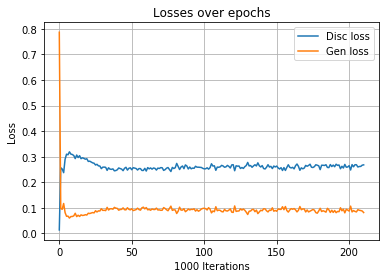

In [24]:
%matplotlib inline

plt.title("Losses over epochs")
plt.grid(True)
plt.xlabel('1000 Iterations')
plt.ylabel('Loss')

plt.plot(xvals, disc_losses, '-', label='Disc loss')
plt.plot(xvals, gen_losses, '-', label='Gen loss')
plt.legend()
plt.show()

### Generate 10 random people

In [25]:
for _ in range(10):
    p = tensor_to_person(generator(torch.randn(GENERATOR_DIM, requires_grad=False) * 10).detach())
    print(p["age"], p["height"], p["weight"], p["sex"])

36.02839279174805 64.37193298339844 283.5968933105469 1
47.380802154541016 70.51559448242188 129.42384338378906 0
47.761924743652344 61.440189361572266 149.24972534179688 1
55.33895492553711 70.27855682373047 90.15535736083984 0
52.409061431884766 48.74726867675781 133.4513397216797 1
27.924991607666016 62.08806610107422 101.28564453125 1
42.67536926269531 71.06471252441406 231.0632781982422 0
37.71642303466797 61.80950164794922 276.104248046875 1
19.72756576538086 62.90214538574219 168.377197265625 0
49.49778366088867 71.81649017333984 293.7549743652344 1


### Create 10000 people in a CSV file

In [26]:
import csv
from faker import Faker

fake = Faker()

with open('generated_data_better.csv', mode='w') as csv_file:
    fieldnames = ['name', 'age', 'height', 'sex', 'race_teal', 'race_blue', 'race_purple', 'race_green', 'resting_heartrate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'weight', 'blood_sugar']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(10000):
        p = tensor_to_person(generator(torch.randn(GENERATOR_DIM, requires_grad=False)).detach())
        p['name'] = fake.name()
        writer.writerow(p)